In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import netCDF4
import xarray as xr
import hmp
from pathlib import Path
from mne.io import read_info
from mne import read_epochs
from hmpai.data import StageFinder, SAT_CLASSES_ACCURACY, SAT_CLASSES_SPEED, SAT1_STAGES_ACCURACY, SAT1_STAGES_SPEED, SAT2_STAGES_ACCURACY, SAT2_STAGES_SPEED, AR_STAGES
from hmpai.ica import ICA
import os
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from hmpai.visualization import set_seaborn_style
DATA_PATH = Path(os.getenv("DATA_PATH"))

In [2]:
# Load dataframe containing all test/val participants and which split they belong to
info_path = DATA_PATH / "sat2/preprocessed_500hz/S1_epo.fif"
positions = read_info(info_path)
epoch = read_epochs(info_path)
epoch.set_montage('biosemi64')
positions = epoch.info
data_paths = [DATA_PATH / "sat2/stage_data_proba_250hz_45ms_tertile.nc"]
# Shouldnt matter which dataset this is right?
datasets = [xr.open_dataset(path) for path in data_paths]

Reading /workspace/data_local/sat2/preprocessed_500hz/S1_epo.fif ...


    Found the data of interest:
        t =    -300.00 ...    4000.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
2376 matching events found
No baseline correction applied
0 projection items activated


In [3]:
# datasets[0] = datasets[0].sel(participant=['S10'])

In [3]:
conditions = np.unique(datasets[0].condition).tolist()
tertiles = np.unique(datasets[0].tertile).tolist()
conditions = [cond for cond in conditions if cond != '']
tertiles = [tert for tert in tertiles if not np.isnan(tert)]
combinations = list(itertools.product(conditions, tertiles))
tert_names = ['Low', 'Med', 'High']

In [6]:
fit_ac = hmp.utils.load_fit("../pipeline/250hz_accuracy_45ms.nc")
fit_sp = hmp.utils.load_fit("../pipeline/250hz_speed_45ms.nc")
n_events_to_fix = 2
prepars_ac = fit_ac.parameters.data[:n_events_to_fix]
premags_ac = fit_ac.magnitudes.data[:n_events_to_fix]
prepars_sp = fit_sp.parameters.data[:n_events_to_fix]
premags_sp = fit_sp.magnitudes.data[:n_events_to_fix]

Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:539: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


SAT: accuracy, tertile: Low
Fitting HMP model


  0%|          | 0/151 [00:00<?, ?it/s]

Transition event 1 found around sample 12
Transition event 2 found around sample 42
Transition event 3 found around sample 136

All events found, refitting final combination.
Estimating 3 events model
parameters estimated for 3 events model
SAT: accuracy, tertile: Med
Fitting HMP model


  0%|          | 0/174 [00:00<?, ?it/s]

Transition event 1 found around sample 12
Transition event 2 found around sample 50
Transition event 3 found around sample 90
Transition event 4 found around sample 142

All events found, refitting final combination.
Estimating 4 events model
parameters estimated for 4 events model
SAT: accuracy, tertile: High
Fitting HMP model


  0%|          | 0/172 [00:00<?, ?it/s]

Transition event 1 found around sample 12
Transition event 2 found around sample 55
Transition event 3 found around sample 109
Transition event 4 found around sample 133

All events found, refitting final combination.
Estimating 4 events model
parameters estimated for 4 events model
SAT: speed, tertile: Low
Fitting HMP model


  0%|          | 0/77 [00:00<?, ?it/s]

Transition event 1 found around sample 26
Transition event 2 found around sample 65

All events found, refitting final combination.
Estimating 2 events model
parameters estimated for 2 events model
SAT: speed, tertile: Med
Fitting HMP model


  0%|          | 0/103 [00:00<?, ?it/s]

Transition event 1 found around sample 28
Transition event 2 found around sample 82
Transition event 3 found around sample 94

All events found, refitting final combination.
Estimating 3 events model
parameters estimated for 3 events model
SAT: speed, tertile: High
Fitting HMP model


  0%|          | 0/144 [00:00<?, ?it/s]

Transition event 1 found around sample 26
Transition event 2 found around sample 88
Transition event 3 found around sample 120

All events found, refitting final combination.
Estimating 3 events model
parameters estimated for 3 events model


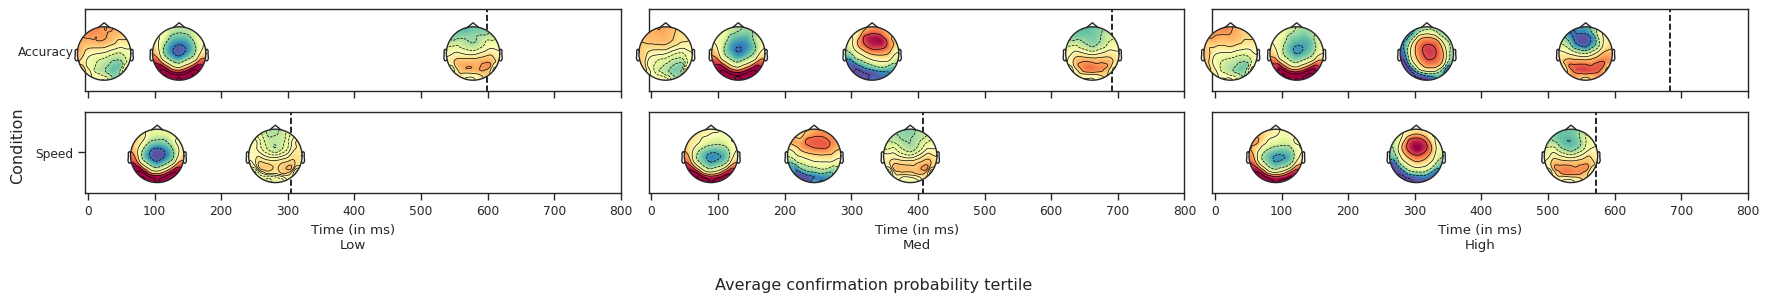

In [8]:
finder = StageFinder(
    datasets[0],
    labels=SAT_CLASSES_ACCURACY,
    fit_function="fit",
    event_width=45,
    n_comp=10,
    cpus=0,
    conditions=[],
)
fig, ax = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(18, 3))
for i, (cond, tert) in enumerate(combinations):
    tert_name = tert_names[int(tert)]
    print(f"SAT: {cond}, tertile: {tert_name}")
    if cond == 'accuracy':
        prepars = prepars_ac
        premags = premags_ac
    elif cond == 'speed':
        prepars = prepars_sp
        premags = premags_sp
    else:
        raise ValueError(f'cond {cond} not recognized.')
    cur_ax = ax[conditions.index(cond), tertiles.index(tert)]
    # At this point, data is only labelled with tertile for participants in test/val sets
    # finder.fit_model(fit_args={"prepars": prepars, "premags": premags}, extra_split=[("condition", "equal", cond), ("tertile", "equal", tert)])
    finder.fit_model(extra_split=[("condition", "equal", cond), ("tertile", "equal", tert)])
    # finder.fit_model(fit_args={"by_sample": True}, extra_split=[("condition", "equal", cond), ("tertile", "equal", tert)])
    finder.visualize_model(positions, max_time=800, ax=cur_ax, colorbar=cond=='High', cond_label=cond.capitalize(), model_index=i)
    if cond == 'speed':
        cur_ax.set_xlabel(f"Time (in ms)\n{tert_name}")
    if tert_name == 'Low':
        cur_ax.set_yticks([0.5], [cond.capitalize()])
    else:
        cur_ax.set_yticks([], [])
    
fig.supxlabel("Average confirmation probability tertile")
fig.supylabel("Condition")
fig.tight_layout()
plt.show()

#### Fit testing

In [ ]:
combinations = list(
    itertools.product(splits["SAT"].unique(), splits["condition"].unique())
)
results = []
fig, axes = plt.subplots(len(combinations), 1, sharex=True, figsize=(12, 8))
for i, (sat, cond) in enumerate(combinations):
    print(f"SAT: {sat}, Condition: {cond}")
    data_indices = splits[(splits.SAT == sat) & (splits.condition == cond)]
    selected = []
    for participant, epoch in zip(data_indices["participant"], data_indices["epochs"]):
        for dataset in datasets:
            matching_datasets = [
                ds for ds in datasets if participant in ds.participant.values
            ]
            for dataset in matching_datasets:
                selection = dataset.sel(participant=participant, epochs=epoch)
                selection = selection.expand_dims(
                dim={"participant": [participant], "epochs": [epoch]}
                )
                # if 'labels' in selection.dims and 'labels' not in selection.coords:
                #     selection = selection.assign_coords(labels=("labels", range(selection.sizes['labels'])))
                selected.append(selection)
    subset = xr.combine_by_coords(selected)
    if sat == 'accuracy':
        prepars = prepars_ac
        premags = premags_ac
    else:
        prepars = prepars_sp
        premags = premags_sp
    finder = StageFinder(
        subset,
        labels=SAT_CLASSES_ACCURACY,
        fit_function="fit",
        # fit_args={"step": 5},
        # fit_args={"by_sample": True, "prepars": prepars, "premags": premags},
        fit_args={"step": 5, "prepars": prepars, "premags": premags},
        # fit_args={"by_sample": True},
        n_comp=10,
        cpus=8,
        conditions=[],
        event_width=50,
    )
    finder.fit_model()
    hmp.utils.save_fit(finder.fits[0], f"fits/{sat}_{cond}.nc")

    ax = finder.visualize_model(positions, max_time=800, ax=axes[i])
    axes[i].set_yticklabels([f"{sat}, {cond}"])
    # results.append({'SAT': sat, 'condition': cond, 'n_events': len(labels) - 1, 'log_likelihood': likelihood})
    # Subset datasets
fig.tight_layout()
plt.show()

In [7]:
fig.savefig("../../img/final.svg", transparent=True)

#### Visualization (horizontal)

Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:530: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Fitting HMP model
Loading fitted HMP model for No condition


/opt/conda/lib/python3.10/site-packages/xarray/core/dataarray.py:3178: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'trial_x_participant'} to avoid an error in the future.
  ds = self._to_temp_dataset().drop_vars(names, errors=errors)


Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:530: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Fitting HMP model
Loading fitted HMP model for No condition


/opt/conda/lib/python3.10/site-packages/xarray/core/dataarray.py:3178: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'trial_x_participant'} to avoid an error in the future.
  ds = self._to_temp_dataset().drop_vars(names, errors=errors)


Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:530: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Fitting HMP model
Loading fitted HMP model for No condition


/opt/conda/lib/python3.10/site-packages/xarray/core/dataarray.py:3178: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'trial_x_participant'} to avoid an error in the future.
  ds = self._to_temp_dataset().drop_vars(names, errors=errors)


Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:530: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Fitting HMP model
Loading fitted HMP model for No condition


/opt/conda/lib/python3.10/site-packages/xarray/core/dataarray.py:3178: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'trial_x_participant'} to avoid an error in the future.
  ds = self._to_temp_dataset().drop_vars(names, errors=errors)


Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:530: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Fitting HMP model
Loading fitted HMP model for No condition


/opt/conda/lib/python3.10/site-packages/xarray/core/dataarray.py:3178: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'trial_x_participant'} to avoid an error in the future.
  ds = self._to_temp_dataset().drop_vars(names, errors=errors)


Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:530: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Fitting HMP model
Loading fitted HMP model for No condition


/opt/conda/lib/python3.10/site-packages/xarray/core/dataarray.py:3178: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'trial_x_participant'} to avoid an error in the future.
  ds = self._to_temp_dataset().drop_vars(names, errors=errors)


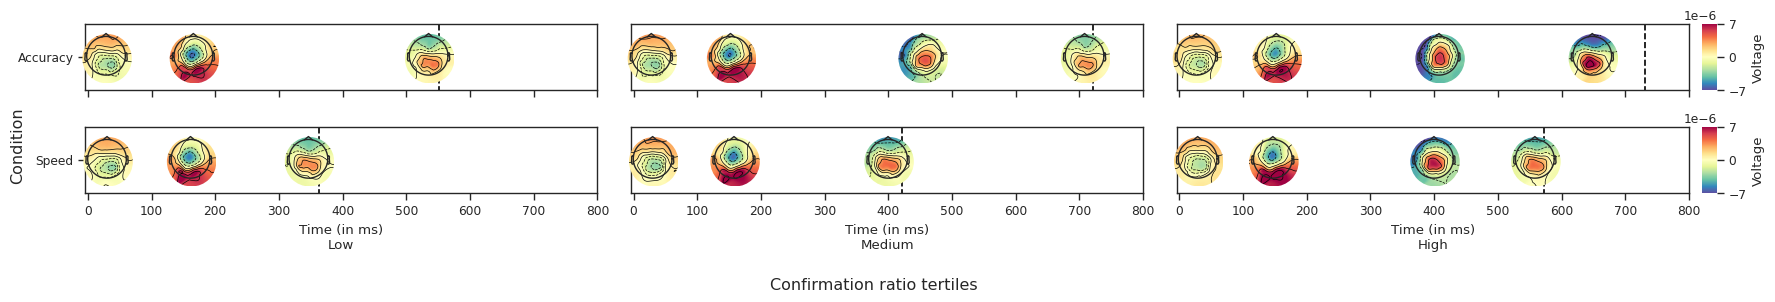

In [ ]:
# Load in all fitted models
combinations = list(itertools.product(splits['SAT'].unique(), splits['condition'].unique()))
fit_path = Path("fits/")
sats = ['accuracy', 'speed']
conds = ['Low', 'Medium', 'High']
fig, ax = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(18, 3))
for sat, cond in combinations:
    data_indices = splits[(splits.SAT == sat) & (splits.condition == cond)]
    selected = []
    for participant, epoch in zip(data_indices["participant"], data_indices["epochs"]):
        for dataset in datasets:
            matching_datasets = [
                ds for ds in datasets if participant in ds.participant.values
            ]
            for dataset in matching_datasets:
                selection = dataset.sel(participant=participant, epochs=epoch)
                selection = selection.expand_dims(
                dim={"participant": [participant], "epochs": [epoch]}
                )
                selected.append(selection)
    subset = xr.combine_by_coords(selected)
    finder = StageFinder(
        subset,
        labels=SAT_CLASSES_ACCURACY,
        fit_function="fit",
        # fit_args={"by_sample": True},
        n_comp=10,
        cpus=8,
        conditions=[],
        fits_to_load=[fit_path / f"{sat}_{cond}.nc"],
        event_width=50,
    )
    finder.fit_model()
    cur_ax = ax[sats.index(sat), conds.index(cond)]
    finder.visualize_model(positions, max_time=800, ax=cur_ax, colorbar=cond=='High', cond_label=sat.capitalize())
    if sat == 'speed':
        cur_ax.set_xlabel(f"Time (in ms)\n{cond}")
    if cond == 'Low':
        cur_ax.set_yticks([0.5], [sat.capitalize()])
    else:
        cur_ax.set_yticks([], [])
fig.supxlabel("Average confirmation probability tertile")
fig.supylabel("Condition")
fig.tight_layout()
fig.savefig("../../img/refit.svg", transparent=True)

#### Visualization (vertical)

Transforming epoched data to principal component (PC) space
Fitting HMP model
Loading fitted HMP model for No condition
Transforming epoched data to principal component (PC) space
Fitting HMP model
Loading fitted HMP model for No condition
Transforming epoched data to principal component (PC) space
Fitting HMP model
Loading fitted HMP model for No condition
Transforming epoched data to principal component (PC) space
Fitting HMP model
Loading fitted HMP model for No condition
Transforming epoched data to principal component (PC) space
Fitting HMP model
Loading fitted HMP model for No condition
Transforming epoched data to principal component (PC) space
Fitting HMP model
Loading fitted HMP model for No condition


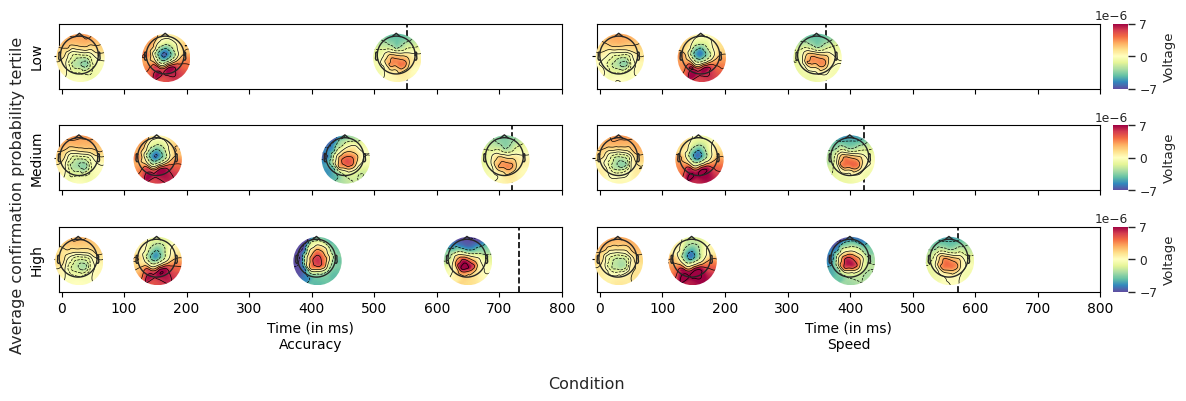

In [4]:
# Load in all fitted models
combinations = list(itertools.product(splits['SAT'].unique(), splits['condition'].unique()))
fit_path = Path("fits/")
sats = ['accuracy', 'speed']
conds = ['Low', 'Medium', 'High']
fig, ax = plt.subplots(3, 2, sharex=True, sharey=False, figsize=(12, 4))  # Adjusted the layout and size for 3x2 grid

for idx, (sat, cond) in enumerate(combinations):
    data_indices = splits[(splits.SAT == sat) & (splits.condition == cond)]
    selected = []
    
    for participant, epoch in zip(data_indices["participant"], data_indices["epochs"]):
        matching_datasets = [
            ds for ds in datasets if participant in ds.participant.values
        ]
        for dataset in matching_datasets:
            selection = dataset.sel(participant=participant, epochs=epoch)
            selection = selection.expand_dims(
                dim={"participant": [participant], "epochs": [epoch]}
            )
            selected.append(selection)
    
    subset = xr.combine_by_coords(selected)
    finder = StageFinder(
        subset,
        labels=SAT_CLASSES_ACCURACY,
        fit_function="fit",
        # fit_args={"by_sample": True},
        n_comp=10,
        cpus=8,
        conditions=[],
        fits_to_load=[fit_path / f"{sat}_{cond}.nc"],
        event_width=50,
    )
    finder.fit_model()
    
    # Determine the subplot position based on index in a 3x2 grid
    row, col = conds.index(cond), sats.index(sat)
    cur_ax = ax[row, col]
    
    # Visualize model in the current subplot
    finder.visualize_model(positions, max_time=800, ax=cur_ax, colorbar=col == 1, cond_label=None)
    
    # Label axes
    if row == 2:
        cur_ax.set_xlabel(f"Time (in ms)\n{sat.capitalize()}")
    if col == 0:
        cur_ax.set_ylabel(cond)
    cur_ax.set_yticks([0.5], [None])

# Set common labels and save figure
fig.supylabel("Average confirmation probability tertile")
fig.supxlabel("Condition")
fig.tight_layout()
fig.savefig("../../img/refit_stacked.svg", transparent=True)


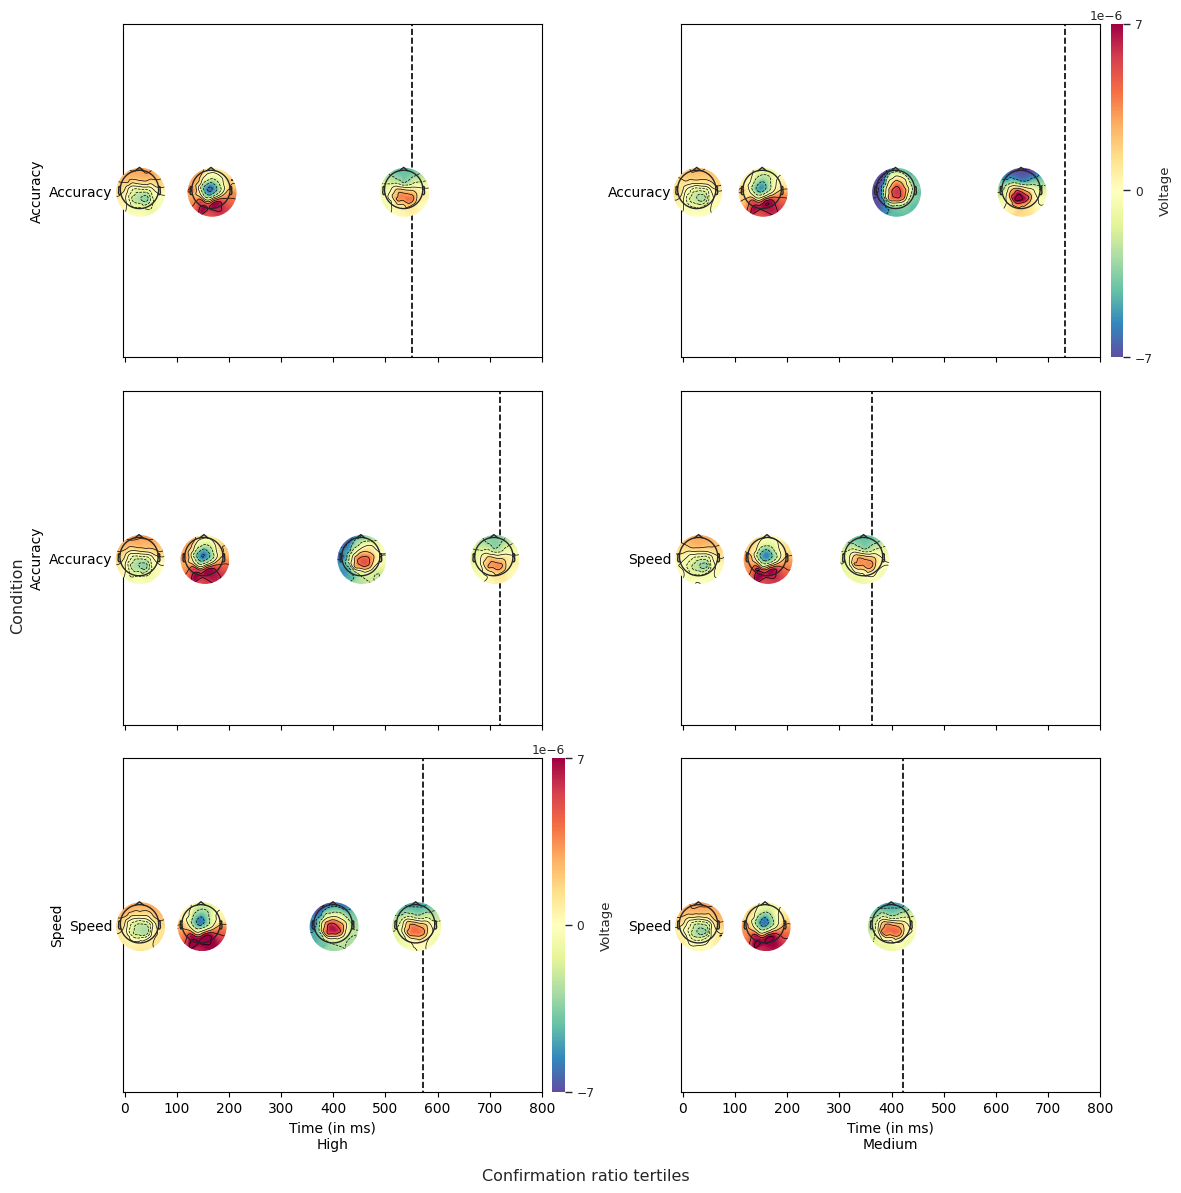

In [ ]:

fig

## Compare likelihoods (deprecated)

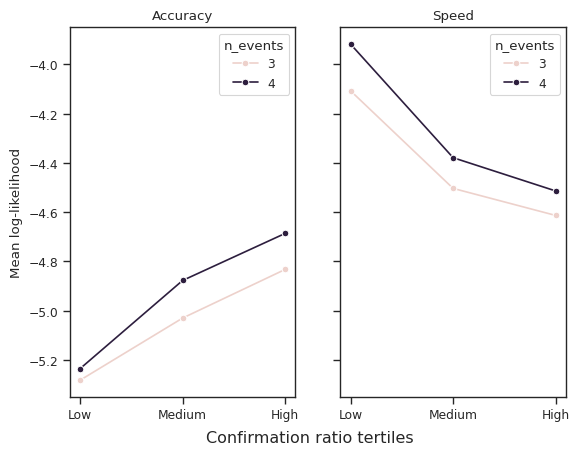

In [61]:

set_seaborn_style()
fig, ax = plt.subplots(1, 2, sharey=True)
order = ['Low', 'Medium', 'High']

fig.supxlabel('Confirmation ratio tertiles')
sns.lineplot(data[data['SAT'] == 'accuracy'], x='condition', y='log_likelihood', hue='n_events', ax=ax[0], marker="o")
sns.lineplot(data[data['SAT'] == 'speed'], x='condition', y='log_likelihood', hue='n_events', ax=ax[1], marker="o")

ax[0].set_title('Accuracy')
ax[1].set_title('Speed')
ax[0].set_ylabel('Mean log-likelihood')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
plt.show()

In [ ]:
combinations = list(itertools.product(splits['SAT'].unique(), splits['condition'].unique()))
results = []
for sat, cond in combinations:
    print(f"SAT: {sat}, Condition: {cond}")
    data_indices = splits[(splits.SAT == sat) & (splits.condition == cond)]
    selected = []
    for dataset in datasets:
        for participant, epoch in zip(data_indices['participant'], data_indices['epochs']):
            if participant in dataset.participant.values:
                selection = dataset.sel(participant=participant, epochs=epoch)
                selection = selection.expand_dims(dim={'participant': [participant], 'epochs': [epoch]})
                selected.append(selection)
    subset = xr.combine_by_coords(selected)
    # 4 entries in labels == 3 event model, 5 entries == 4 event model
    for labels in [['0', '1', '2', '3'], ['0', '1', '2', '3', '4']]:
        finder = StageFinder(subset, labels=labels, fit_function='fit_single', fit_args={"starting_points": 50}, n_comp=10, cpus=8, conditions=[])
        finder.fit_model()
        likelihood = finder.fits[0].likelihoods.item()
        # Take average log-likelihood by dividing over amount of trials
        likelihood = likelihood / len(finder.fits[0].trial_x_participant)
        print(f"Events: {len(labels) - 1}, likelihood: {likelihood}")
        results.append({'SAT': sat, 'condition': cond, 'n_events': len(labels) - 1, 'log_likelihood': likelihood})
    # Subset datasets